In [1]:
import numpy as np

from pyspark.ml.feature import StringIndexer, OneHotEncoder

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler, StandardScaler
from pyspark.ml import Pipeline

from pyspark.ml.regression import LinearRegression

from pyspark.ml.regression import DecisionTreeRegressor

from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import time

In [3]:
data=spark.read.csv(path="insurance.csv", sep=",", header=True, inferSchema=True)

In [4]:
data.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

# Data Exploration

In [5]:
data.columns

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [6]:
len(data.columns)

7

In [7]:
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [8]:
data.head(2)

[Row(age=19, sex='female', bmi=27.9, children=0, smoker='yes', region='southwest', charges=16884.924),
 Row(age=18, sex='male', bmi=33.77, children=1, smoker='no', region='southeast', charges=1725.5523)]

In [9]:
data.select("charges").show(15)

+-----------+
|    charges|
+-----------+
|  16884.924|
|  1725.5523|
|   4449.462|
|21984.47061|
|  3866.8552|
|  3756.6216|
|  8240.5896|
|  7281.5056|
|  6406.4107|
|28923.13692|
|  2721.3208|
| 27808.7251|
|   1826.843|
| 11090.7178|
| 39611.7577|
+-----------+
only showing top 15 rows



In [10]:
data.count()

1338

In [11]:
data.groupby('smoker').count().show()

+------+-----+
|smoker|count|
+------+-----+
|    no| 1064|
|   yes|  274|
+------+-----+



In [12]:
data.groupby('children').count().show()

+--------+-----+
|children|count|
+--------+-----+
|       1|  324|
|       3|  157|
|       5|   18|
|       4|   25|
|       2|  240|
|       0|  574|
+--------+-----+



In [13]:
data.groupby('sex').count().show()

+------+-----+
|   sex|count|
+------+-----+
|female|  662|
|  male|  676|
+------+-----+



In [14]:
data.describe().show()

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|  null|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|  null|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+



In [15]:
data.select("age").show()

+---+
|age|
+---+
| 19|
| 18|
| 28|
| 33|
| 32|
| 31|
| 46|
| 37|
| 37|
| 60|
| 25|
| 62|
| 23|
| 56|
| 27|
| 19|
| 52|
| 23|
| 56|
| 30|
+---+
only showing top 20 rows



In [16]:
data.corr('age','bmi')

0.1092718815485351

In [17]:
vc1=VectorAssembler(
    inputCols=['age',"bmi",'children','charges'],
    outputCol='numeric')
dx1=vc1.transform(data).select('numeric')

In [18]:
dx1.show()

+--------------------+
|             numeric|
+--------------------+
|[19.0,27.9,0.0,16...|
|[18.0,33.77,1.0,1...|
|[28.0,33.0,3.0,44...|
|[33.0,22.705,0.0,...|
|[32.0,28.88,0.0,3...|
|[31.0,25.74,0.0,3...|
|[46.0,33.44,1.0,8...|
|[37.0,27.74,3.0,7...|
|[37.0,29.83,2.0,6...|
|[60.0,25.84,0.0,2...|
|[25.0,26.22,0.0,2...|
|[62.0,26.29,0.0,2...|
|[23.0,34.4,0.0,18...|
|[56.0,39.82,0.0,1...|
|[27.0,42.13,0.0,3...|
|[19.0,24.6,1.0,18...|
|[52.0,30.78,1.0,1...|
|[23.0,23.845,0.0,...|
|[56.0,40.3,0.0,10...|
|[30.0,35.3,0.0,36...|
+--------------------+
only showing top 20 rows



In [19]:
data.columns

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [20]:
abc1=data.toPandas()

In [21]:
abc1.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [22]:
data.select('*').where(data.charges.isNull()).count()

0

In [23]:
from pyspark.sql.functions import isnan, when, count, col
def get_null_value_count(data):
    data.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in data.columns]).show()

In [24]:
get_null_value_count(data)

+---+---+---+--------+------+------+-------+
|age|sex|bmi|children|smoker|region|charges|
+---+---+---+--------+------+------+-------+
|  0|  0|  0|       0|     0|     0|      0|
+---+---+---+--------+------+------+-------+



In [25]:
data.dtypes

[('age', 'int'),
 ('sex', 'string'),
 ('bmi', 'double'),
 ('children', 'int'),
 ('smoker', 'string'),
 ('region', 'string'),
 ('charges', 'double')]

In [26]:
 cat_cols1=[c[0] for c in data.dtypes if c[1]=="string"]

In [27]:
cat_cols1

['sex', 'smoker', 'region']

In [28]:
num_cols1=[c[0] for c in data.dtypes if c[1]!="string"]
num_cols1

['age', 'bmi', 'children', 'charges']

In [29]:
num_cols1=num_cols1[0:3]
num_cols1

['age', 'bmi', 'children']

In [30]:
ohe_cols1=[c+"_ohe" for c in cat_cols1]
ohe_cols1

['sex_ohe', 'smoker_ohe', 'region_ohe']

In [31]:
cat_cols_si1= [c+"_index" for c in cat_cols1]
print (cat_cols_si1)

['sex_index', 'smoker_index', 'region_index']


In [32]:
cat_cols_ohe1= [c+"_ohe" for c in cat_cols1]
print (cat_cols_ohe1)

['sex_ohe', 'smoker_ohe', 'region_ohe']


In [33]:
assembler1 = VectorAssembler(inputCols=['age', 'bmi', 'children'], outputCol = 'Attributes')

output1 = assembler1.transform(data)

#Input vs Output
finalized_data1 = output1.select("Attributes", 'charges')

finalized_data1.show()

+-----------------+-----------+
|       Attributes|    charges|
+-----------------+-----------+
|  [19.0,27.9,0.0]|  16884.924|
| [18.0,33.77,1.0]|  1725.5523|
|  [28.0,33.0,3.0]|   4449.462|
|[33.0,22.705,0.0]|21984.47061|
| [32.0,28.88,0.0]|  3866.8552|
| [31.0,25.74,0.0]|  3756.6216|
| [46.0,33.44,1.0]|  8240.5896|
| [37.0,27.74,3.0]|  7281.5056|
| [37.0,29.83,2.0]|  6406.4107|
| [60.0,25.84,0.0]|28923.13692|
| [25.0,26.22,0.0]|  2721.3208|
| [62.0,26.29,0.0]| 27808.7251|
|  [23.0,34.4,0.0]|   1826.843|
| [56.0,39.82,0.0]| 11090.7178|
| [27.0,42.13,0.0]| 39611.7577|
|  [19.0,24.6,1.0]|   1837.237|
| [52.0,30.78,1.0]| 10797.3362|
|[23.0,23.845,0.0]| 2395.17155|
|  [56.0,40.3,0.0]|  10602.385|
|  [30.0,35.3,0.0]|  36837.467|
+-----------------+-----------+
only showing top 20 rows



In [34]:
data.groupby('region').count().show()

+---------+-----+
|   region|count|
+---------+-----+
|northwest|  325|
|southeast|  364|
|northeast|  324|
|southwest|  325|
+---------+-----+



In [35]:
data.groupby('region').count().orderBy("count", ascending=False).first()[0]

'southeast'

In [36]:
[[i, data.groupby(i).count().orderBy("count", ascending=False).first()[0]] for i in data.columns]

[['age', 18],
 ['sex', 'male'],
 ['bmi', 32.3],
 ['children', 0],
 ['smoker', 'no'],
 ['region', 'southeast'],
 ['charges', 1639.5631]]

In [38]:
## Pipeline
pipe = Pipeline(
                stages=[
                    StringIndexer(
                        inputCols=cat_cols1,
                        outputCols=cat_cols_si1
                    ),
                    OneHotEncoder(
                        inputCols=cat_cols_si1,
                        outputCols=ohe_cols1
                    ),
                    VectorAssembler(
                        inputCols=cat_cols_si1+num_cols1,
                        outputCol="ass_features"
                    ),
                    StandardScaler(
                        inputCol="ass_features",
                        outputCol="features"
                    )
                ]
    )

In [40]:
cat_cols1

['sex', 'smoker', 'region']

In [41]:
model1=pipe.fit(data)

data_trans1=model1.transform(data)

In [42]:
print (data_trans1.columns)

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'sex_index', 'smoker_index', 'region_index', 'sex_ohe', 'smoker_ohe', 'region_ohe', 'ass_features', 'features']


In [43]:
len(data.columns)

7

In [44]:
len(data_trans1.columns)

15

# Train-Test Split

In [45]:
train, test=data.randomSplit([0.75,0.25], seed=12345)

In [46]:
train.count()

1017

In [47]:
test.count()

321

# Linear Regression

In [49]:
pipe = Pipeline(
                stages=[
                 
                    StringIndexer(
                        inputCols=cat_cols1,
                        handleInvalid='keep',
                        outputCols=cat_cols_si1
                    ),
                    OneHotEncoder(
                        inputCols=cat_cols_si1,
                        outputCols=ohe_cols1
                    ),
                    VectorAssembler(
                        inputCols=cat_cols_si1+num_cols1,
                        outputCol="ass_features"
                    ),
                    StandardScaler(
                        inputCol="ass_features",
                        outputCol="features"
                    ),
                    LinearRegression(featuresCol= 'features', labelCol='charges')
                ]
    )

In [50]:
# Training of model
start=time.time()
lrModel=pipe.fit(train)
end=time.time()
(end-start)/60

0.046072769165039065

# Prediction of Linear Regression

In [51]:
predictions1=lrModel.transform(test)

In [52]:
predictions1.columns

['age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'region',
 'charges',
 'sex_index',
 'smoker_index',
 'region_index',
 'sex_ohe',
 'smoker_ohe',
 'region_ohe',
 'ass_features',
 'features',
 'prediction']

In [53]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="charges", predictionCol="prediction")

In [54]:
print('RMSE:', eval.evaluate(predictions1, {eval.metricName: "rmse"}))
print('R-squared:', eval.evaluate(predictions1, {eval.metricName: "r2"}))

RMSE: 6208.781642295839
R-squared: 0.7213557804083071


# Random Forest Regressor

In [56]:
pipe3 = Pipeline(
                stages=[
                 
                    StringIndexer(
                        inputCols=cat_cols1,
                        handleInvalid='keep',
                        outputCols=cat_cols_si1
                    ),
                    OneHotEncoder(
                        inputCols=cat_cols_si1,
                        outputCols=ohe_cols1
                    ),
                    VectorAssembler(
                        inputCols=cat_cols_si1+num_cols1,
                        outputCol="ass_features"
                    ),
                    StandardScaler(
                        inputCol="ass_features",
                        outputCol="features"
                    ),
                    RandomForestRegressor( labelCol="charges", featuresCol="features")
                ]
    )

In [57]:
rf = RandomForestRegressor(labelCol="charges", featuresCol="features")

In [58]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [59]:
# Evaluate model
rfevaluator1 = RegressionEvaluator(predictionCol="prediction", labelCol="charges", metricName="rmse")

In [60]:
crossval = CrossValidator(estimator=pipe3,
                          estimatorParamMaps=paramGrid,
                          evaluator=rfevaluator1,
                          numFolds=3)

In [61]:
cvModel = crossval.fit(train)

In [62]:
predictions = cvModel.transform(test)

# Random Forest Regressor

In [63]:
import matplotlib.pyplot as plt
evaluator = RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="rmse")
rmse_rf = evaluator.evaluate(predictions)
rfPred = cvModel.transform(data)
rfResult = rfPred.toPandas()

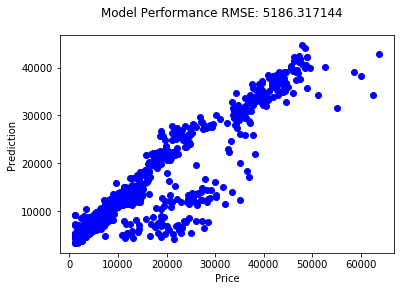

In [64]:
plt.plot(rfResult.charges, rfResult.prediction, 'bo')
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse_rf)
plt.show()

# Gradient Boosting Regressor

In [65]:
from pyspark.ml.regression import GBTRegressor

In [67]:
pipe4 = Pipeline(
                stages=[
                 
                    StringIndexer(
                        inputCols=cat_cols1,
                        handleInvalid='keep',
                        outputCols=cat_cols_si1
                    ),
                    OneHotEncoder(
                        inputCols=cat_cols_si1,
                        outputCols=ohe_cols1
                    ),
                    VectorAssembler(
                        inputCols=cat_cols_si1+num_cols1,
                        outputCol="ass_features"
                    ),
                    StandardScaler(
                        inputCol="ass_features",
                        outputCol="features"
                    ),
                   GBTRegressor(featuresCol="features", labelCol='charges',maxIter=10)
                ]
    )

In [68]:
# Train model.  This also runs the indexer.
model = pipe4.fit(train)

# Make predictions.
predictions = model.transform(test)

In [69]:
evaluator = RegressionEvaluator(
    labelCol="charges", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4667.81


# Model Selection

In [70]:
import pandas as pd
model_errors= pd.DataFrame({
    "Model": ["LinearRegession","RandomForestRegressor"],
    "Score": [rmse,rmse_rf]
})

In [71]:
model_errors.sort_values(by='Score',ascending=True)

,Model,Score
0,LinearRegession,4667.811183
1,RandomForestRegressor,5186.317144
